# DISCLAIMER: This Notebook can only be executed when models are loaded. However, the .keras model files could not be included into the submission as each file was too big (>500MB).

In [2]:
import os
import io
import tensorflow as tf
import numpy as np
from azure.storage.blob import BlobServiceClient, ContainerClient
from azure.core.exceptions import ResourceNotFoundError
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import time
from keras.models import load_model
import tempfile

import pandas as pd
from tensorflow.keras import layers, models
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from keras.utils import plot_model
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

## Help Functions

In [4]:
image_size=224
channels=3
autotune = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically


def plot_history(model):
    """Plots the accuracy and loss of the inputted model."""
    # summarize history for accuracy
    plt.plot(model.history['accuracy'])
    plt.plot(model.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    

def create_labels (labels):
    y_labels = []
    for label in labels: 
        y_labels.append(label)
    y_labels = np.array(y_labels)
    return y_labels


def true_and_predicted_classes(predictions, labels):
    predicted_classes = []
    true_classes = []
    for prediction in predictions:  
        pred = np.argmax(prediction)
        predicted_classes.append(pred)
    for label in labels: 
        true = np.argmax(label)
        true_classes.append(true)
    return predicted_classes, true_classes


def print_predictions(labels, preds, predictions):
    """Predictions based on test dataset."""
    #predict
    for label,pred, prediction in zip(labels, preds, predictions):
        
            print("Prediction:", prediction,"Pred. Class: ",pred, "Actual Label:", label)# Print the first prediction
        

def evaluate_model(model, X_test, y_test):
    result = model.evaluate(X_test, y_test)
    # Assuming accuracy was the second metric (index 1), extract the accuracy.
    test_accuracy = result[1] * 100  # Convert to percentage
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy


def print_conf_matrix(true_classes, predicted_classes):
    """
    Print confusion matrix.
    """
    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    df_cm = pd.DataFrame(
        conf_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=(8,5))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues')

    # Set aesthetics for better readability
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()


def plot_image(index, images, labels):
    """
    Plots a single image with its predicted and actual labels.
    """
    # Get a single image from X_val
    image = images[index]

    # Get the true label for the image
    y_true = np.argmax(labels[index])

    # Plot the image 
    plt.figure(figsize=(3, 3))
    plt.imshow(image, cmap='bone')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"Label: {class_names[y_true]}")
    plt.title("Image with Predicted and Actual Labels")
    plt.show()

def plot_image_pred(model, index, images, labels):
    """
    Plots a single image with its predicted and actual labels.
    """
    # Get a single image from X_val
    image = images[index]

    # Get the true label for the image
    y_true = np.argmax(labels[index])

    # Predict the label using the model
    y_pred = np.argmax(model.predict(np.expand_dims(image, axis=0)))

    plt.figure(figsize=(3, 3))
    plt.imshow(image, cmap='bone')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"True: {class_names[y_true]}\nPred: {class_names[y_pred]}",
               color='black' if y_true == y_pred else 'red')
    plt.title("Image with Predicted and Actual Labels")
    plt.show()


def plot_wrong_pred_image(images, true_classes, predicted_classes):
    """
    Plots a single image with its predicted and actual labels.
    """
    mismatch =  [i for i in range(len(true_classes)) if true_classes[i] != predicted_classes[i]]
    random_nr = random.choice(mismatch)
    # Get a single image from X_val
    image = images[random_nr]

    # Get the true label for the image
    y_true = true_classes[random_nr]

    # Predict the label using the model
    y_pred = predicted_classes[random_nr]

    plt.figure(figsize=(3, 3))
    plt.imshow(image, cmap='bone')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"True: {class_names[y_true]}\nPred: {class_names[y_pred]}",
               color='black' if y_true == y_pred else 'red')
    plt.title("Wrong predicted image")
    plt.show()
    
def plot_correct_pred_image(images, true_classes, predicted_classes):
    """
    Plots a single image with its predicted and actual labels.
    """
    mismatch =  [i for i in range(len(true_classes)) if true_classes[i] == predicted_classes[i]]
    random_nr = random.choice(mismatch)
    # Get a single image from X_val
    image = images[random_nr]

    # Get the true label for the image
    y_true = true_classes[random_nr]

    # Predict the label using the model
    y_pred = predicted_classes[random_nr]

    plt.figure(figsize=(3, 3))
    plt.imshow(image, cmap='bone')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"True: {class_names[y_true]}\nPred: {class_names[y_pred]}")
    plt.title("Correct predicted image")
    plt.show()


## Load Data

In [6]:
#read csv files to get filepaths and labels 
df_train= pd.read_csv("FINAL_METER_ML_train_2000.csv")
df_val = pd.read_csv("FINAL_METER_ML_val.csv")
df_test = pd.read_csv("FINAL_METER_ML_test.csv")

# convert each string in the DataFrame to a list
df_train['Label'] = df_train['Label'].apply(ast.literal_eval).apply(np.array)
df_val['Label'] = df_val['Label'].apply(ast.literal_eval).apply(np.array)
df_test['Label'] = df_test['Label'].apply(ast.literal_eval).apply(np.array)


#define class names for later use
class_names=["CAFOs","Landfills","Mines","Negative","ProcessingPlants","RefineriesAndTerminals","WWTreatment"]

#convert the label labels to arrays in a list
y_train = np.array(df_train['Label']).tolist()
y_val = np.array(df_val['Label']).tolist()
y_test = np.array(df_test['Label']).tolist()


#import images from previous created .npy files from personal drive
X_val = np.load('/Volumes/SSD/x_val.npy')
X_test = np.load('/Volumes/SSD/x_test.npy')
X_train = np.load('/Volumes/SSD/x_train.npy')

#create labels
y_val = create_labels(y_val)
y_train = create_labels(y_train)
y_test = create_labels(y_test)


## RESNET

In [7]:
resnet_model = tf.keras.models.load_model("/Volumes/SSD/RUNS/HATI/RUN2/resnet_model.keras")


In [8]:
predictions = resnet_model.predict(X_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step


In [9]:
evaluate_model(resnet_model, X_test, y_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.4878 - loss: 1.4934
Test Accuracy: 35.86%


35.85858643054962

In [10]:
true_classes_rn, predicted_classes_rn = true_and_predicted_classes(predictions, y_test)

In [11]:
print(f"Accuracy Score: {accuracy_score(true_classes_rn, predicted_classes_rn)}")
print(f"F1 Score: {f1_score(true_classes_rn, predicted_classes_rn, average='weighted')}")
print(f"Recall Score: {recall_score(true_classes_rn, predicted_classes_rn, average='weighted')}")
print(f"Precision Score: {precision_score(true_classes_rn, predicted_classes_rn, average='weighted')}")

Accuracy Score: 0.35858585858585856
F1 Score: 0.3728123972390291
Recall Score: 0.35858585858585856
Precision Score: 0.5086434170476751


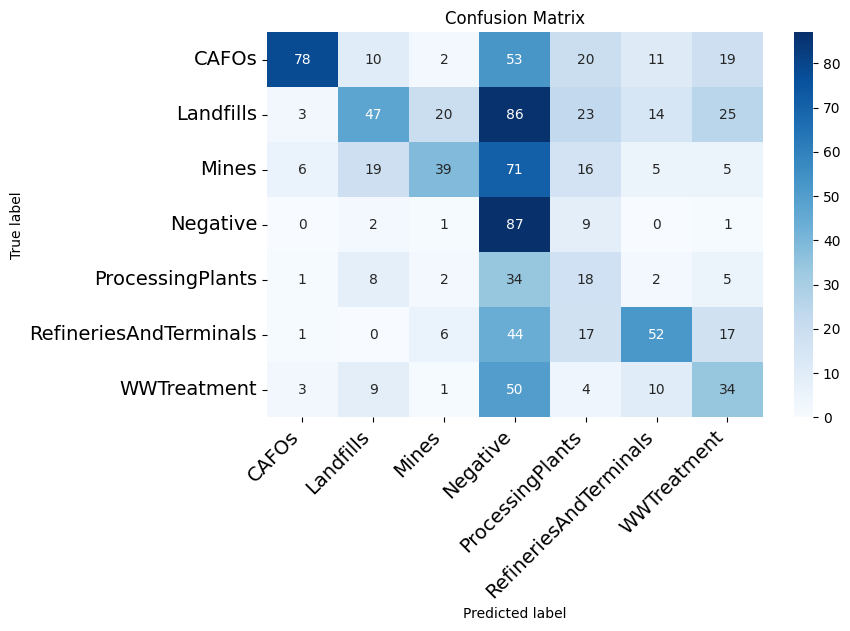

In [12]:
print_conf_matrix(true_classes_rn, predicted_classes_rn)

In [13]:
from sklearn.metrics import classification_report

report_rn = classification_report(true_classes_rn, predicted_classes_rn)
print(report_rn)


              precision    recall  f1-score   support

           0       0.85      0.40      0.55       193
           1       0.49      0.22      0.30       218
           2       0.55      0.24      0.34       161
           3       0.20      0.87      0.33       100
           4       0.17      0.26      0.20        70
           5       0.55      0.38      0.45       137
           6       0.32      0.31      0.31       111

    accuracy                           0.36       990
   macro avg       0.45      0.38      0.35       990
weighted avg       0.51      0.36      0.37       990



## RESNET FINE TUNING

In [15]:
resnet_model_ft = tf.keras.models.load_model("/Volumes/SSD/RUNS/HATI/RUN2/resnet_model_tf.keras")


In [16]:
predictions_rn_ft = resnet_model_ft.predict(X_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step


In [17]:
evaluate_model(resnet_model_ft, X_test, y_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.4918 - loss: 1.6528
Test Accuracy: 44.44%


44.44444477558136

In [18]:
true_classes_ft, predicted_classes_ft = true_and_predicted_classes(predictions_rn_ft, y_test)

In [19]:
print(f"Accuracy Score: {accuracy_score(true_classes_ft, predicted_classes_ft)}")
print(f"F1 Score: {f1_score(true_classes_ft, predicted_classes_ft, average='weighted')}")
print(f"Recall Score: {recall_score(true_classes_ft, predicted_classes_ft, average='weighted')}")
print(f"Precision Score: {precision_score(true_classes_ft, predicted_classes_ft, average='weighted')}")

Accuracy Score: 0.4444444444444444
F1 Score: 0.43885851494715156
Recall Score: 0.4444444444444444
Precision Score: 0.4925293456110719


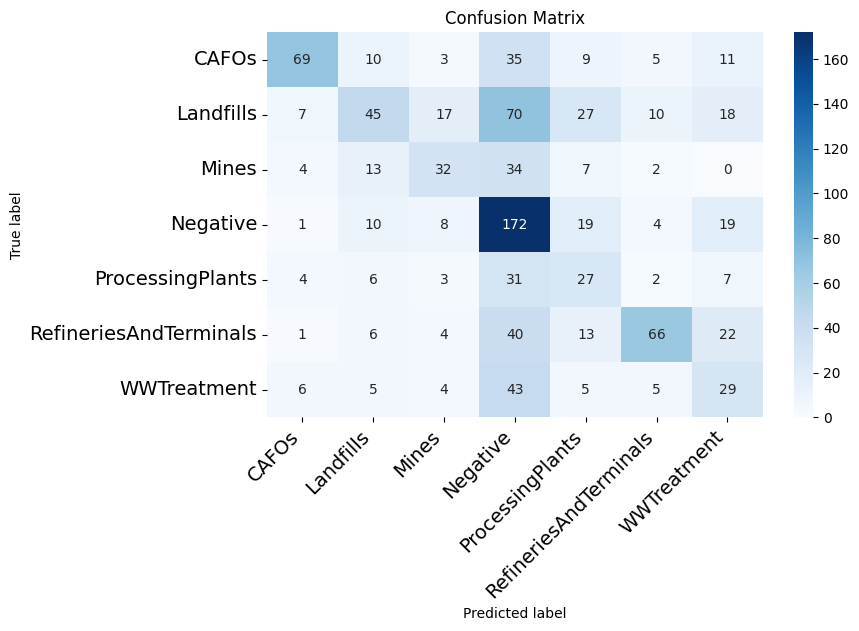

In [20]:
print_conf_matrix(true_classes_ft, predicted_classes_ft)

In [21]:
report_ft = classification_report(true_classes_ft, predicted_classes_ft)
print(report_ft)

              precision    recall  f1-score   support

           0       0.75      0.49      0.59       142
           1       0.47      0.23      0.31       194
           2       0.45      0.35      0.39        92
           3       0.40      0.74      0.52       233
           4       0.25      0.34      0.29        80
           5       0.70      0.43      0.54       152
           6       0.27      0.30      0.29        97

    accuracy                           0.44       990
   macro avg       0.47      0.41      0.42       990
weighted avg       0.49      0.44      0.44       990



## ALEXNET

In [22]:
alexnet = tf.keras.models.load_model("/Volumes/SSD/RUNS/KORE/alexnet.keras")


In [23]:
predictions_an = alexnet.predict(X_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 529ms/step


In [24]:
evaluate_model(alexnet, X_test, y_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 517ms/step - accuracy: 0.5372 - loss: 1.3585
Test Accuracy: 41.62%


41.61616265773773

In [25]:
true_classes_an, predicted_classes_an = true_and_predicted_classes(predictions_an, y_test)

In [26]:
print(f"Accuracy Score: {accuracy_score(true_classes_an, predicted_classes_an)}")
print(f"F1 Score: {f1_score(true_classes_an, predicted_classes_an, average='weighted')}")
print(f"Recall Score: {recall_score(true_classes_an, predicted_classes_an, average='weighted')}")
print(f"Precision Score: {precision_score(true_classes_an, predicted_classes_an, average='weighted')}")

Accuracy Score: 0.4161616161616162
F1 Score: 0.4236494992676936
Recall Score: 0.4161616161616162
Precision Score: 0.5509366125227915


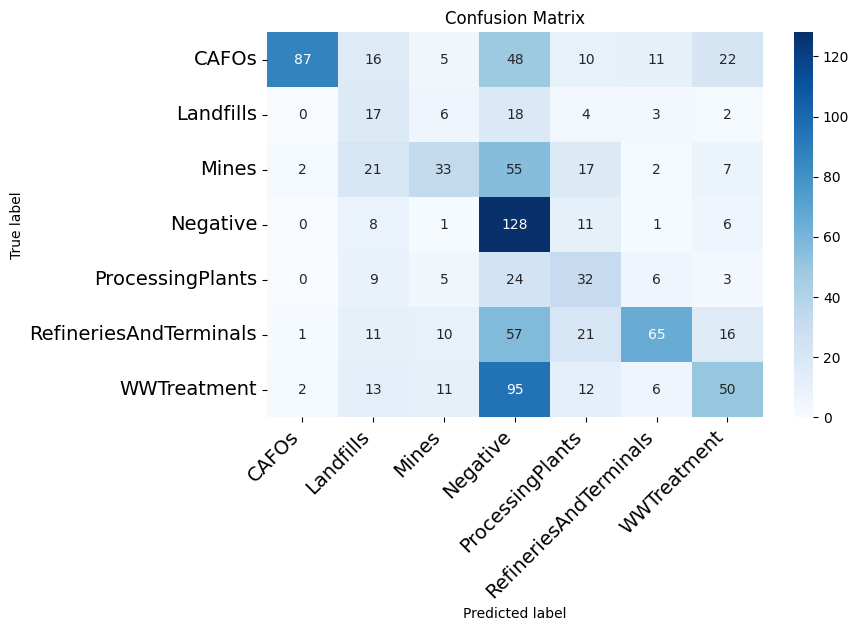

In [27]:
print_conf_matrix(true_classes_an, predicted_classes_an)

In [28]:
report_an = classification_report(true_classes_an, predicted_classes_an)
print(report_an)

              precision    recall  f1-score   support

           0       0.95      0.44      0.60       199
           1       0.18      0.34      0.23        50
           2       0.46      0.24      0.32       137
           3       0.30      0.83      0.44       155
           4       0.30      0.41      0.34        79
           5       0.69      0.36      0.47       181
           6       0.47      0.26      0.34       189

    accuracy                           0.42       990
   macro avg       0.48      0.41      0.39       990
weighted avg       0.55      0.42      0.42       990



## VGG16

In [29]:
vgg16 = tf.keras.models.load_model("/Volumes/SSD/RUNS/KORE/VGG16_model_2.keras")


In [30]:
predictions_vgg = vgg16.predict(X_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 243s 8s/step


In [31]:
evaluate_model(vgg16, X_test, y_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 221s 7s/step - accuracy: 0.5608 - loss: 1.3135
Test Accuracy: 46.16%


46.16161584854126

In [36]:
true_classes_vgg, predicted_classes_vgg = true_and_predicted_classes(predictions_vgg, y_test)

In [37]:
print(f"Accuracy Score: {accuracy_score(true_classes_vgg, predicted_classes_vgg)}")
print(f"F1 Score: {f1_score(true_classes_vgg, predicted_classes_vgg, average='weighted')}")
print(f"Recall Score: {recall_score(true_classes_vgg, predicted_classes_vgg, average='weighted')}")
print(f"Precision Score: {precision_score(true_classes_vgg, predicted_classes_vgg, average='weighted')}")

Accuracy Score: 0.4616161616161616
F1 Score: 0.4531259074348555
Recall Score: 0.4616161616161616
Precision Score: 0.5722660511083569


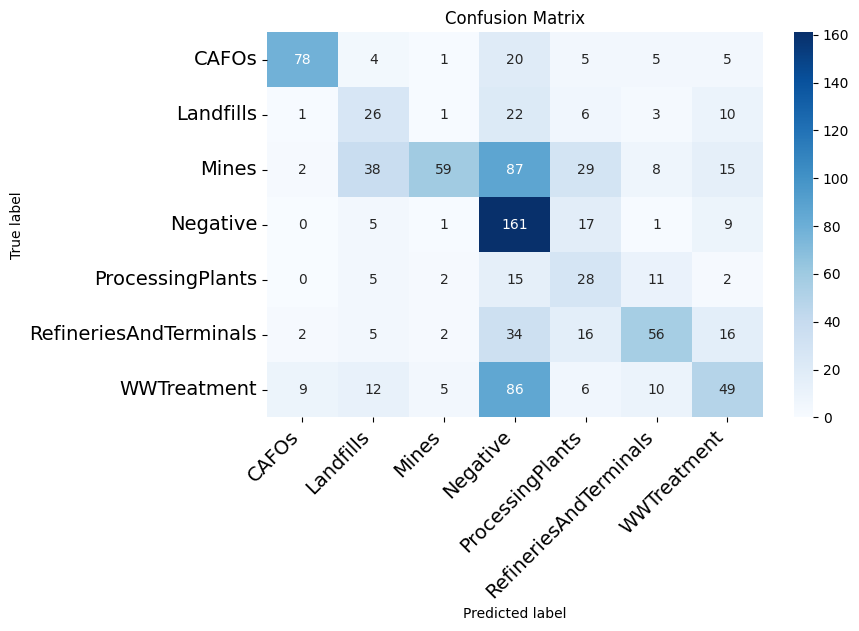

In [38]:
print_conf_matrix(true_classes_vgg, predicted_classes_vgg)

In [39]:
report_vgg = classification_report(true_classes_vgg, predicted_classes_vgg)
print(report_vgg)

              precision    recall  f1-score   support

           0       0.85      0.66      0.74       118
           1       0.27      0.38      0.32        69
           2       0.83      0.25      0.38       238
           3       0.38      0.83      0.52       194
           4       0.26      0.44      0.33        63
           5       0.60      0.43      0.50       131
           6       0.46      0.28      0.35       177

    accuracy                           0.46       990
   macro avg       0.52      0.47      0.45       990
weighted avg       0.57      0.46      0.45       990



## Plot Images